# Задание 1

## 1.1
Приведите таблицу в удобный вид (на ваш вкус) и приложите в формате Excel

In [3]:
import pandas as pd
import numpy as np

df = pd.read_excel('ab_test_levels2.xlsx', skiprows = 7)
df

,\tFormula,\tSegment,\tlevel_number,\tlevel_number.1,\tlevel_number.2,\tlevel_number.3,\t2021-03-31 to 2021-06-29
0,\tFormula A: UNIQUES(A),\tCohort A,1,\t,\t,\t,5057
1,\tFormula A: UNIQUES(A),\tCohort A,2,\t,\t,\t,4724
2,\tFormula A: UNIQUES(A),\tCohort A,3,\t,\t,\t,4363
3,\tFormula A: UNIQUES(A),\tCohort A,4,\t,\t,\t,3925
4,\tFormula A: UNIQUES(A),\tCohort A,5,\t,\t,\t,3590
...,...,...,...,...,...,...,...
1192,\tFormula E: TOTALS(D),\tCohort B,\t,\t,\t,33,25
1193,\tFormula E: TOTALS(D),\tCohort B,\t,\t,\t,112,25
1194,\tFormula E: TOTALS(D),\tCohort B,\t,\t,\t,101,24
1195,\tFormula E: TOTALS(D),\tCohort B,\t,\t,\t,105,20


In [4]:
# уберем лишний символ "\t" и заполним пустые ячейки значением NaN
df = df.replace('\t','',regex=True)
df = df.replace(r'^\s*$', np.nan, regex=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   	Formula                   1197 non-null   object 
 1   	Segment                   1197 non-null   object 
 2   	level_number              480 non-null    float64
 3   	level_number.1            240 non-null    float64
 4   	level_number.2            237 non-null    float64
 5   	level_number.3            240 non-null    float64
 6   	2021-03-31 to 2021-06-29  1197 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 65.6+ KB


In [6]:
df.head()

,\tFormula,\tSegment,\tlevel_number,\tlevel_number.1,\tlevel_number.2,\tlevel_number.3,\t2021-03-31 to 2021-06-29
0,Formula A: UNIQUES(A),Cohort A,1.0,NaN,NaN,NaN,5057
1,Formula A: UNIQUES(A),Cohort A,2.0,NaN,NaN,NaN,4724
2,Formula A: UNIQUES(A),Cohort A,3.0,NaN,NaN,NaN,4363
3,Formula A: UNIQUES(A),Cohort A,4.0,NaN,NaN,NaN,3925
4,Formula A: UNIQUES(A),Cohort A,5.0,NaN,NaN,NaN,3590


In [7]:
# проверим, не дублируется ли номер уровня в нескольких колонках. 
# для этого посчитаем количество отсутствующих значений (NaN) и отсортируем в порядке убывания
df.isnull().sum(axis = 1).sort_values(ascending = False)

1196    3
392     3
394     3
395     3
396     3
       ..
797     3
798     3
799     3
800     3
0       3
Length: 1197, dtype: int64

In [8]:
# значения не дублируются. Объединим данные в один столбец
df['level_number'] = df.iloc[:,2:6].sum(axis = 1)

In [9]:
# удалим ненужные столбцы
df = df.drop(columns = ['\tlevel_number', '\tlevel_number.1', '\tlevel_number.2', '\tlevel_number.3'], axis = 1)

# переименуем оставшиеся столбцы
df.columns = ['formula', 'segment', 'quantity', 'level_number']
df.head()

,formula,segment,quantity,level_number
0,Formula A: UNIQUES(A),Cohort A,5057,1.0
1,Formula A: UNIQUES(A),Cohort A,4724,2.0
2,Formula A: UNIQUES(A),Cohort A,4363,3.0
3,Formula A: UNIQUES(A),Cohort A,3925,4.0
4,Formula A: UNIQUES(A),Cohort A,3590,5.0


In [10]:
# развернем столбец 'formula' на 5 отдельных столбцов
df = df.groupby(['formula', 'segment', 'level_number'])['quantity'].sum().unstack('formula').sort_values(by = 'level_number').reset_index()

# переименуем столбцы
df.columns = ['segment', 'level_number', 'unique_start_qty', 'start_qty', 'won_qty', 'losed_qty', 'quit_qty']
df

,segment,level_number,unique_start_qty,start_qty,won_qty,losed_qty,quit_qty
0,Cohort A,1.0,5057.0,5131.0,4902.0,NaN,464.0
1,Cohort B,1.0,5196.0,5272.0,4995.0,NaN,493.0
2,Cohort A,2.0,4724.0,4759.0,4600.0,12.0,147.0
3,Cohort B,2.0,4801.0,4845.0,4629.0,13.0,157.0
4,Cohort A,3.0,4363.0,4464.0,4175.0,72.0,223.0
...,...,...,...,...,...,...,...
235,Cohort A,118.0,327.0,654.0,327.0,296.0,95.0
236,Cohort B,119.0,313.0,607.0,313.0,258.0,99.0
237,Cohort A,119.0,319.0,754.0,318.0,401.0,100.0
238,Cohort A,120.0,315.0,445.0,316.0,94.0,58.0


In [11]:
# отсутствующие значения заполним нулями
df.fillna(0, inplace = True)

# заменим тип данных float на целочисленный
df.iloc[:,1:] = df.iloc[:,1:].astype(int)

# сохраним результат в файл Matryoshka.csv
df.to_csv('Matryoshka.csv')

In [12]:
df.head()

,segment,level_number,unique_start_qty,start_qty,won_qty,losed_qty,quit_qty
0,Cohort A,1,5057,5131,4902,0,464
1,Cohort B,1,5196,5272,4995,0,493
2,Cohort A,2,4724,4759,4600,12,147
3,Cohort B,2,4801,4845,4629,13,157
4,Cohort A,3,4363,4464,4175,72,223


## 1.2
Для каждого уровня в обеих когортах посчитайте процент отвала игроков


In [22]:
df['outflow_rate'] = (df.groupby('segment')['unique_start_qty']).apply(lambda x: (abs(x - x.shift(1))/x.shift(1)*100)).round(1)

data_test = df.groupby(['segment', 'level_number'])['outflow_rate'].sum().unstack('segment')
data_test

segment,Cohort A,Cohort B
level_number,,
1,0.0,0.0
2,6.6,7.6
3,7.6,9.4
4,10.0,9.9
5,8.5,9.3
...,...,...
116,1.2,1.5
117,0.9,0.6
118,0.6,0.6


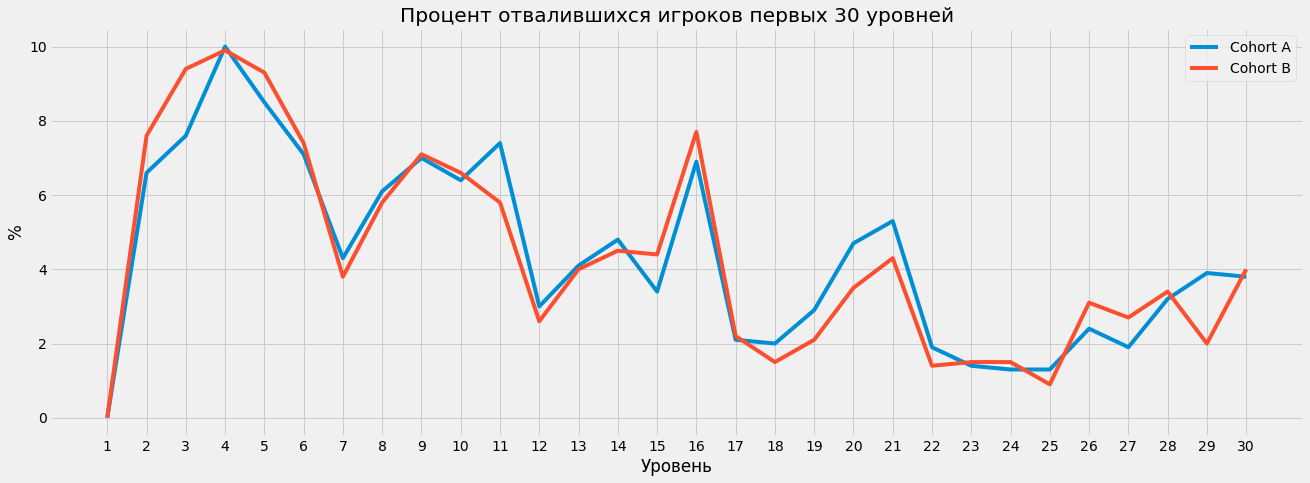

In [23]:
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

data_test = data_test.reset_index().head(30)

plt.figure(figsize = (20,7))

plt.plot(data_test['level_number'], data_test['Cohort A'])
plt.plot(data_test['level_number'], data_test['Cohort B'])

plt.title('Процент отвалившихся игроков первых 30 уровней')
plt.xlabel('Уровень')
plt.ylabel('%')
plt.xticks(np.arange(1, len(data_test)+1))
plt.legend(['Cohort A','Cohort B'])

plt.show()

## 1.3
Какие еще сведения способные улучшить игру можно получить из этих данных? Внесите их в вашу таблицу.


In [16]:
# посчитаем процент удержанных игроков по уровням
df['retention_rate'] = (df.groupby('segment')['unique_start_qty']).apply(lambda x: (x / max(x)) * 100).round(1)
df

,segment,level_number,unique_start_qty,start_qty,won_qty,losed_qty,quit_qty,outflow_rate,retention_rate
0,Cohort A,1,5057,5131,4902,0,464,NaN,100.0
1,Cohort B,1,5196,5272,4995,0,493,NaN,100.0
2,Cohort A,2,4724,4759,4600,12,147,6.6,93.4
3,Cohort B,2,4801,4845,4629,13,157,7.6,92.4
4,Cohort A,3,4363,4464,4175,72,223,7.6,86.3
...,...,...,...,...,...,...,...,...,...
235,Cohort A,118,327,654,327,296,95,0.6,6.5
236,Cohort B,119,313,607,313,258,99,0.9,6.0
237,Cohort A,119,319,754,318,401,100,2.4,6.3
238,Cohort A,120,315,445,316,94,58,1.3,6.2


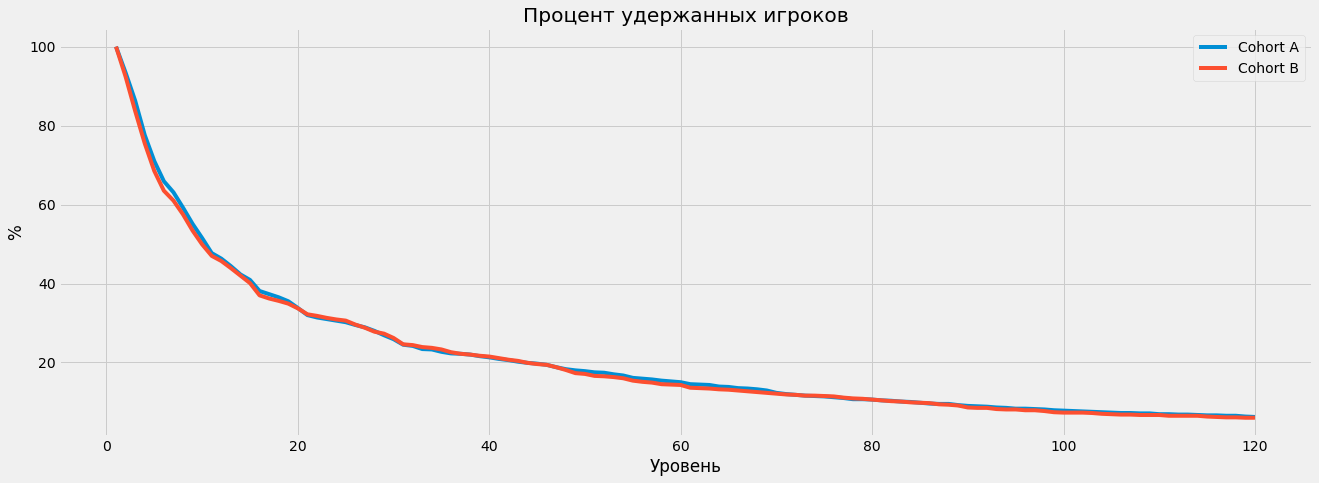

In [17]:
# визуализируем удержание игроков
data_retention = df.groupby(['segment', 'level_number'])['retention_rate'].sum().unstack('segment').reset_index()

plt.figure(figsize = (20,7))

plt.plot(data_retention['level_number'], data_retention['Cohort A'])
plt.plot(data_retention['level_number'], data_retention['Cohort B'])

plt.title('Процент удержанных игроков')
plt.xlabel('Уровень')
plt.ylabel('%')
plt.legend(['Cohort A','Cohort B'])

plt.show()

Только 6% игроков остаются в игре до последнего уровня вне зависимости от когорты

In [18]:
# посчитаем количество попыток для каждого уровня
df['number_of_attempts'] = (df['start_qty'] / df['unique_start_qty']).round(1)

In [19]:
# посчитаем процент проигрышей для каждого уровня
df['loose_rate'] = ((df['losed_qty'] / df['start_qty'])*100).round(1)
df.head()

,segment,level_number,unique_start_qty,start_qty,won_qty,losed_qty,quit_qty,outflow_rate,retention_rate,number_of_attempts,loose_rate
0,Cohort A,1,5057,5131,4902,0,464,NaN,100.0,1.0,0.0
1,Cohort B,1,5196,5272,4995,0,493,NaN,100.0,1.0,0.0
2,Cohort A,2,4724,4759,4600,12,147,6.6,93.4,1.0,0.3
3,Cohort B,2,4801,4845,4629,13,157,7.6,92.4,1.0,0.3
4,Cohort A,3,4363,4464,4175,72,223,7.6,86.3,1.0,1.6


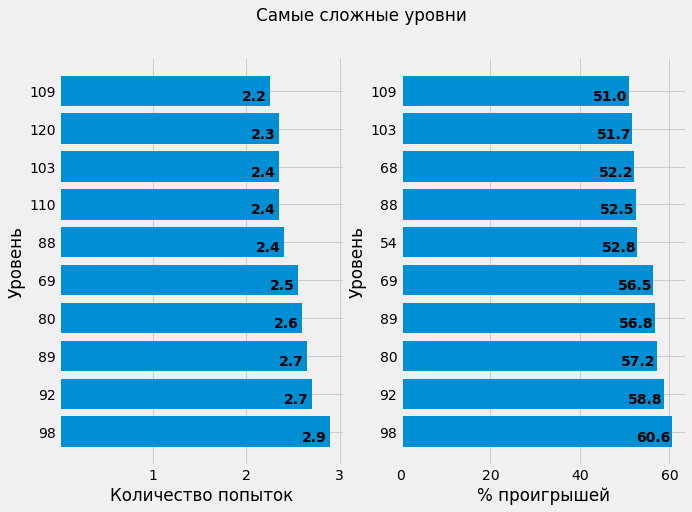

In [20]:
# отобразим 10 самых сложных уровней по агрегированным данным когорты А и когорты В
data_by_attempts = df.groupby('level_number')['number_of_attempts'].mean().reset_index().sort_values(by = 'number_of_attempts', ascending = False).head(10)
data_by_attempts['level_number'] = data_by_attempts['level_number'].apply(str)

data_by_loose = df.groupby('level_number')['loose_rate'].mean().reset_index().sort_values(by = 'loose_rate', ascending = False).head(10)
data_by_loose['level_number'] = data_by_loose['level_number'].apply(str)

plt.figure(figsize = (10,7))
plt.subplot (1, 2, 1)
plt.suptitle('Самые сложные уровни')
plt.barh(data_by_attempts['level_number'], data_by_attempts['number_of_attempts'])
plt.xlabel('Количество попыток')
plt.ylabel('Уровень')
plt.xticks(np.arange(1,4))
for i, v in enumerate(data_by_attempts['number_of_attempts']):
    plt.text(v-0.3, i-0.25, str(round(v,1)), color='black', fontweight='bold')

plt.subplot (1, 2, 2)
plt.barh(data_by_loose['level_number'], data_by_loose['loose_rate'])
plt.xlabel('% проигрышей')
plt.ylabel('Уровень')
for i, v in enumerate(data_by_loose['loose_rate']):
    plt.text(v-8, i-0.25, str(round(v,1)), color='black', fontweight='bold')   

plt.show()

Самый сложный уровень - 98. Для его прохождения необходимо в среднем 3 попытки. Доля проигрышей на этом уровне = 60.6%

## 1.4
Перед вами стоит выбор - заменить старые 30 уровней новыми, или нет? Почему?

In [24]:
# посчитаем показатели А/В теста
data_test

segment,level_number,Cohort A,Cohort B
0,1,0.0,0.0
1,2,6.6,7.6
2,3,7.6,9.4
3,4,10.0,9.9
4,5,8.5,9.3
5,6,7.1,7.4
6,7,4.3,3.8
7,8,6.1,5.8
8,9,7.0,7.1
9,10,6.4,6.6


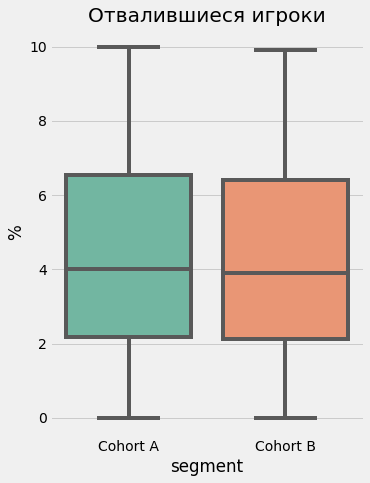

In [25]:
# визуализируем наличие различий в группах аб-теста

import seaborn as sns

plt.figure(figsize=(5, 7))
ax = sns.boxplot(data=data_test[['Cohort A','Cohort B']], palette="Set2")
plt.ylabel('%')
plt.title('Отвалившиеся игроки')
plt.show()

В среднем, количество отвалившихся игроков в когорте В ненамного меньше, чем в когорте А. Также немного меньше значение третьего квартиля. Посчитаем p-value

In [26]:
# считаем значимость различий по аб-тесту
import scipy.stats as stats
t_stat, p_val= stats.ttest_ind(data_test['Cohort A'],data_test['Cohort B'])
t_stat , p_val

(0.0638803152435365, 0.9492851818862708)

Поскольку значимость A/B теста 0.95 больше допустимого уровня значимости 0,05, то мы принимаем нулевую гипотезу о равенстве конверсий в группах, т.е. когорты А и В статистически равны. С точки зрения отвала игроков разница в сложности начальных уровней игры Rescue Team статистически незначима. Уровни можно не менять.

In [27]:
# проведем еще один A/B тест на предмет дошли ли игроки до 31 уровня или нет
data_test = df.groupby(['segment', 'level_number'])['unique_start_qty'].sum().unstack('segment').reset_index()
data_test = data_test.iloc[[0,30],:]
data_test = data_test.drop('level_number', axis = 1).T
data_test.index.name = None
data_test

,0,30
Cohort A,5057,1237
Cohort B,5196,1278


In [28]:
# создаем таблицу сопряженности на основе результатов A/B-теста
data_test.columns = ['unique_start_qty', 'in']
data_test['out'] = data_test['unique_start_qty'] - data_test['in']
data_test = data_test.drop(['unique_start_qty'], axis = 1)
data_test.head()

,in,out
Cohort A,1237,3820
Cohort B,1278,3918


In [29]:
# определяем значимость аб-теста методом хи-квадрат
import scipy.stats as stats
result = stats.chi2_contingency(data_test, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 0.02511779083961147, pvalue = 0.8740739047112432


И снова значимость A/B теста очень высоквая 0.87. Нет статистических предпосылок для замены уровней на новые облегченные.  

# Задание 2

## 2.1
 Основываясь на данных из таблицы сделайте для лучшей, по вашему
мнению,когорты прогноз, какой процент пользователей дойдет до 240, 360, 480,
600 уровня.


In [103]:
# спрогнозируем значения для когорты А
data_retention = data_retention[['level_number','Cohort A']]
data_retention.head()

segment,level_number,Cohort A
0,1,100.0
1,2,93.4
2,3,86.3
3,4,77.6
4,5,71.0


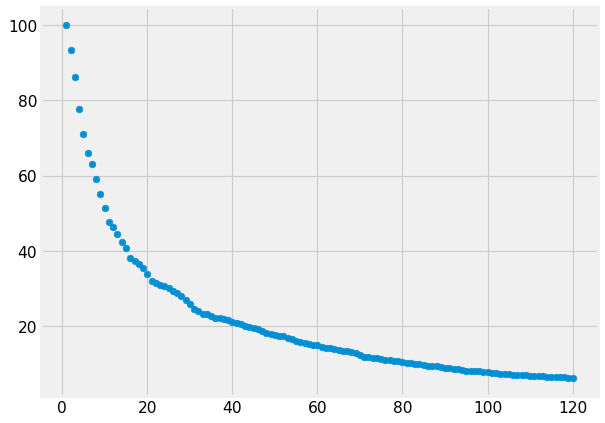

In [31]:
# определяем тип возможной кривой по диаграмме рассеяния

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data_retention['level_number'], data_retention['Cohort A'], label="Original Data" )
plt.show()

In [32]:
# задаем аппроксимирующие функции
def func1( x, a, b, c):
  return a ** (b*x + c)

In [33]:
def func2( x, a, b):
  return a / (x + b )

In [34]:
def func3( x, a, b, c):
  return a / (x+b) + c

In [104]:
def func4( x, a, b, c , d):
  return a / (x*b + c) + d

In [105]:
# подбираем оптимальные параметры функций
from scipy.optimize import curve_fit

func1_popt, func1_pcov = curve_fit(func1, data_retention['level_number'], data_retention['Cohort A'])
func2_popt, func2_pcov = curve_fit(func2, data_retention['level_number'], data_retention['Cohort A'])
func3_popt, func3_pcov = curve_fit(func3, data_retention['level_number'], data_retention['Cohort A'])
func4_popt, func4_pcov = curve_fit(func4, data_retention['level_number'], data_retention['Cohort A'])

In [106]:
# задаем точку прогноза - какой процент пользователей дойдет до 600 уровня
projection_endpoint = 600

In [107]:
# задаем значения функций с помощью метода np.arange и параметров подобранных кривых
func1_y_projected = func1( np.arange( projection_endpoint ), *func1_popt )
func2_y_projected = func2( np.arange( projection_endpoint ), *func2_popt )
func3_y_projected = func3( np.arange( projection_endpoint ), *func3_popt )
func4_y_projected = func4( np.arange( projection_endpoint ), *func4_popt )

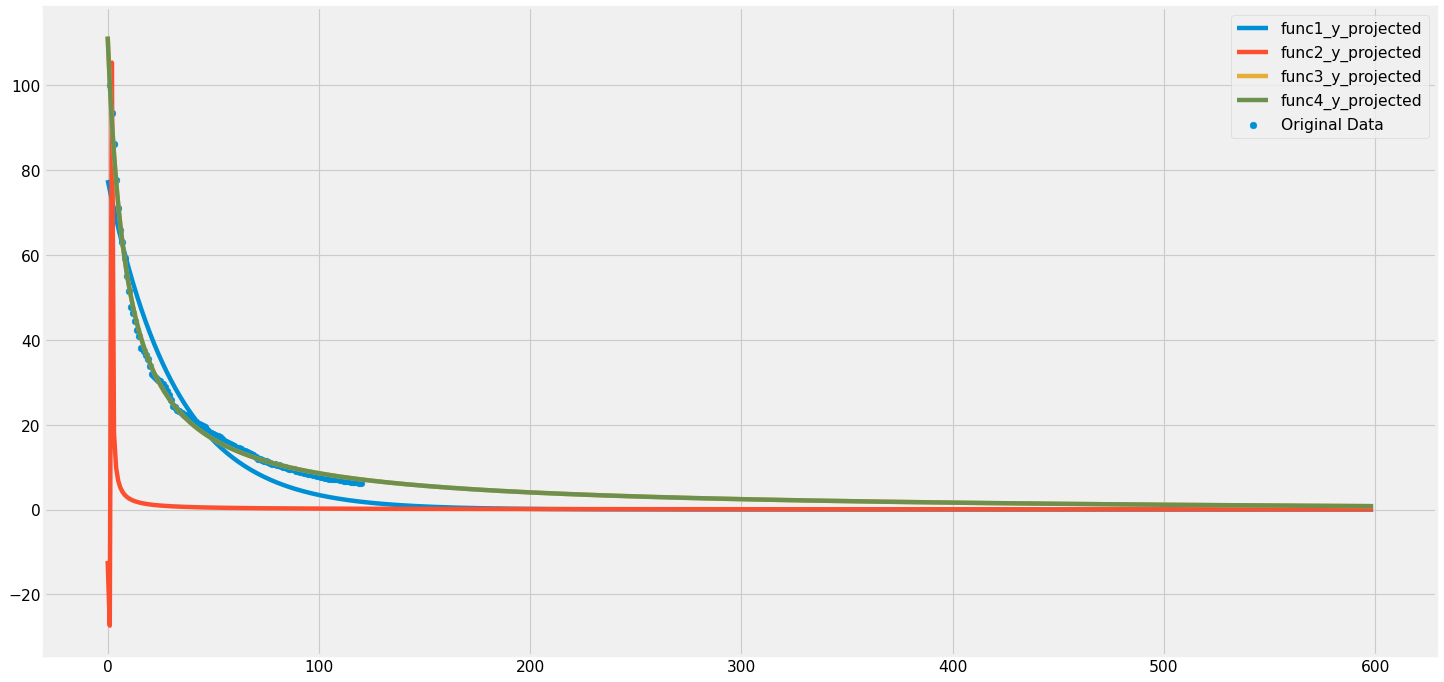

In [108]:
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data_retention['level_number'], data_retention['Cohort A'], label="Original Data" )
plt.plot( func1_y_projected, label="func1_y_projected" )
plt.plot( func2_y_projected, label="func2_y_projected" )
plt.plot( func3_y_projected, label="func3_y_projected" )
plt.plot( func4_y_projected, label="func4_y_projected" )

plt.legend()
plt.show()

Вуаля! Четвертая функция нам подходит. Проверим, насколько она точна

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Средняя абсолютная ошибка:', mean_absolute_error(data_retention.iloc[:,1].values, func4_y_projected[:120]))
print('Среднеквадратичная ошибка:', mean_squared_error(data_retention.iloc[:,1].values, func4_y_projected[:120]))
print('Коэффициент детерминации (r2_score):', r2_score(data_retention.iloc[:,1].values, func4_y_projected[:120]))

Средняя абсолютная ошибка: 1.3010004371532786
Среднеквадратичная ошибка: 4.631206915108466
Коэффициент детерминации (r2_score): 0.9867954758084359


Отличные показатели! Коэффициент детерминации = 0.99, что говорит о точности нашей модели. Спрогнозируем наши значения

In [601]:
print(f'До 240 уровня дойдет {round(func4_y_projected[239],1) }% пользователей')
print(f'До 360 уровня дойдет {round(func4_y_projected[359],1) }% пользователей')
print(f'До 480 уровня дойдет {round(func4_y_projected[479],1) }% пользователей')
print(f'До 600 уровня дойдет {round(func4_y_projected[599],1) }% пользователей')

До 240 уровня дойдет 3.3% пользователей
До 360 уровня дойдет 1.9% пользователей
До 480 уровня дойдет 1.2% пользователей
До 600 уровня дойдет 0.8% пользователей


Так как у меня долго не получалось подобрать функцию, я решила задачку альтернативным способом. Прилагаю и его тоже

## Альтернативное решение

In [41]:
#  У нас равномерное распределение уровней. Создадим равномерный временной ряд, как того требует Prophet()
import datetime
base = datetime.date.today()
date_list = [base - datetime.timedelta(days=x) for x in range(120)]
len(date_list)

120

In [42]:
# добавим стобец с датами 
data_retention['ds'] = sorted(date_list)
data_retention.head()

segment,level_number,Cohort A,ds
0,1,100.0,2021-06-16
1,2,93.4,2021-06-17
2,3,86.3,2021-06-18
3,4,77.6,2021-06-19
4,5,71.0,2021-06-20


In [43]:
# нормализуем долю удержанных игроков для более точного прогноза (без нормализации модель предсказывала с большой погрешностью)
from scipy.stats import boxcox
data_retention['y'], lam = boxcox(data_retention['Cohort A'])

In [44]:
# разделим данные на 75% тренировочных и на 25% тестовых
amount_75 = int(len(data_retention)*0.75)
train_data = data_retention[:amount_75]
test_data = data_retention[amount_75:]

In [45]:
# посмотрим границы тренировчной и тестовой выборок
train_data.head()

segment,level_number,Cohort A,ds,y
0,1,100.0,2021-06-16,1.906063
1,2,93.4,2021-06-17,1.897807
2,3,86.3,2021-06-18,1.887917
3,4,77.6,2021-06-19,1.874041
4,5,71.0,2021-06-20,1.861899


In [46]:
train_data.tail()

segment,level_number,Cohort A,ds,y
85,86,9.6,2021-09-09,1.402949
86,87,9.5,2021-09-10,1.399258
87,88,9.5,2021-09-11,1.399258
88,89,9.2,2021-09-12,1.387838
89,90,9.0,2021-09-13,1.379918


In [47]:
test_data.head()

segment,level_number,Cohort A,ds,y
90,91,8.9,2021-09-14,1.375861
91,92,8.8,2021-09-15,1.371736
92,93,8.6,2021-09-16,1.363277
93,94,8.5,2021-09-17,1.358939
94,95,8.3,2021-09-18,1.350035


In [48]:
test_data.tail()

segment,level_number,Cohort A,ds,y
115,116,6.6,2021-10-09,1.259129
116,117,6.5,2021-10-10,1.252724
117,118,6.5,2021-10-11,1.252724
118,119,6.3,2021-10-12,1.239472
119,120,6.2,2021-10-13,1.232613


In [49]:
# обучим модель
from fbprophet import Prophet
m = Prophet()
m.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
# сделаем предсказания для тестового периода
# последний уровень тренировочных данных - 90 
# последний уровень тестовых данных - 120. Нам нужно сделать предсказания на 30 уровней вперед
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-16,1.907815,1.904445,1.909256,1.907815,1.907815,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,0.0,0.0,0.0,1.906792
1,2021-06-17,1.896577,1.893701,1.898414,1.896577,1.896577,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,0.0,0.0,0.0,1.896135
2,2021-06-18,1.885338,1.883282,1.888167,1.885338,1.885338,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.0,0.0,0.0,1.885640
3,2021-06-19,1.874100,1.873034,1.877938,1.874100,1.874100,0.001335,0.001335,0.001335,0.001335,0.001335,0.001335,0.0,0.0,0.0,1.875435
4,2021-06-20,1.864008,1.862145,1.867077,1.864008,1.864008,0.000588,0.000588,0.000588,0.000588,0.000588,0.000588,0.0,0.0,0.0,1.864596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-10-09,1.256594,1.188589,1.325607,1.187832,1.324197,0.001335,0.001335,0.001335,0.001335,0.001335,0.001335,0.0,0.0,0.0,1.257929
116,2021-10-10,1.251658,1.179858,1.324105,1.178281,1.324220,0.000588,0.000588,0.000588,0.000588,0.000588,0.000588,0.0,0.0,0.0,1.252245
117,2021-10-11,1.246721,1.169872,1.323708,1.169933,1.324500,-0.000405,-0.000405,-0.000405,-0.000405,-0.000405,-0.000405,0.0,0.0,0.0,1.246316
118,2021-10-12,1.241784,1.161155,1.322273,1.162139,1.324107,-0.000355,-0.000355,-0.000355,-0.000355,-0.000355,-0.000355,0.0,0.0,0.0,1.241429


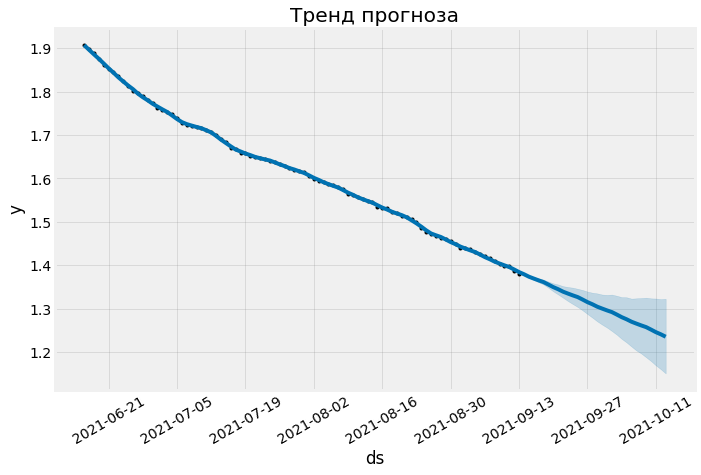

In [51]:
fig1 = m.plot(forecast)
plt.xticks(rotation = 30)
plt.title('Тренд прогноза')
plt.show()

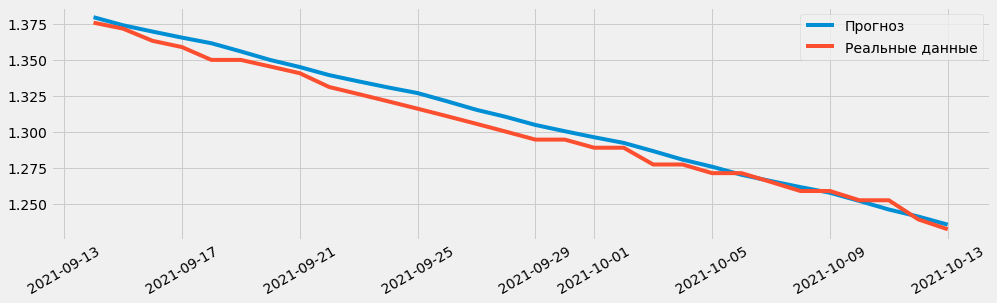

In [52]:
# сравним с тем, что было на самом деле в этот период
plt.figure(figsize=(15,4))
forecast_future = forecast.iloc[90:,:]
plt.plot(forecast_future['ds'], forecast_future['yhat'])
plt.plot(test_data['ds'], test_data['y'])
plt.legend(['Прогноз','Реальные данные'])
plt.xticks(rotation = 30)
plt.show()

In [53]:
# проверим, насколько точна наша модель
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Средняя абсолютная ошибка:', mean_absolute_error(test_data['y'], forecast_future['yhat']))
print('Среднеквадратичная ошибка:', mean_squared_error(test_data['y'], forecast_future['yhat']))
print('Коэффициент детерминации (r2_score):', r2_score(test_data['y'], forecast_future['yhat']))

Средняя абсолютная ошибка: 0.005816414756341418
Среднеквадратичная ошибка: 4.519857608016689e-05
Коэффициент детерминации (r2_score): 0.9726027850491463


Наша модель довольно точна, но все же первое решение с подбором функции было более подходящее

In [54]:
# строим прозноз на 600 уровней
future = m.make_future_dataframe(periods=510)
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-16,1.907815,1.904159,1.909138,1.907815,1.907815,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,0.0,0.0,0.0,1.906792
1,2021-06-17,1.896577,1.893850,1.898562,1.896577,1.896577,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,0.0,0.0,0.0,1.896135
2,2021-06-18,1.885338,1.883278,1.888076,1.885338,1.885338,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.0,0.0,0.0,1.885640
3,2021-06-19,1.874100,1.873195,1.877939,1.874100,1.874100,0.001335,0.001335,0.001335,0.001335,0.001335,0.001335,0.0,0.0,0.0,1.875435
4,2021-06-20,1.864008,1.862085,1.867006,1.864008,1.864008,0.000588,0.000588,0.000588,0.000588,0.000588,0.000588,0.0,0.0,0.0,1.864596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2023-02-01,-1.112992,-7.772918,5.186171,-7.769734,5.186882,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,-0.001023,0.0,0.0,0.0,-1.114014
596,2023-02-02,-1.117928,-7.792787,5.206789,-7.792642,5.206321,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,-0.000441,0.0,0.0,0.0,-1.118370
597,2023-02-03,-1.122865,-7.823735,5.218424,-7.823240,5.217739,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.0,0.0,0.0,-1.122563
598,2023-02-04,-1.127801,-7.850974,5.236944,-7.853658,5.235074,0.001335,0.001335,0.001335,0.001335,0.001335,0.001335,0.0,0.0,0.0,-1.126466


In [55]:
# приведем наши данные по удержанным пользователям к удобному денормализованному формату
from scipy.special import inv_boxcox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [56]:
# добавим в датафрейм forecast наш столбец с уровнями
forecast['level_number'] = np.linspace(1,600,600, dtype='int')

In [57]:
# выберем нужные строки и столбцы для решения поставленной задачи
forecast.iloc[[239,359,479,599],15:]

,yhat,level_number
239,2.147865,240
359,1.054430,360
479,0.617994,480
599,0.402295,600


Таким образом, до 240 уровня дойдет 2,15% пользователей. 
До 360 уровня - 1,05%, 
до 480 - 0,62% 
и до 600 - 0,4%.

Напомним, что значения **первого решения** были такими:
240 уровень -  3.3%, 
360 уровень - 1.9%,
480 уровень -  1.2%,
600 уровень -  0.8%.


## 2.2
Сколько в среднем уровней на данный момент проходит пользователь?

In [58]:
# Посчитаем средневзвешенное значение
data = df.groupby('level_number')['unique_start_qty'].mean().reset_index()
avg_lvl_qty = sum(df['unique_start_qty']*df['level_number'])/sum(df['unique_start_qty'])
avg_lvl_qty

35.61463939308106

In [65]:
# Посчитаем отдельно для когорт А и В
data_A = df[['level_number','unique_start_qty']].loc[df['segment'] == 'Cohort A']
avg_lvl_qty_A = sum(data_A['unique_start_qty']*data_A['level_number'])/sum(data_A['unique_start_qty'])
avg_lvl_qty_A

35.71416378316032

In [60]:
data_B = df[['level_number','unique_start_qty']].loc[df['segment'] == 'Cohort B']
avg_lvl_qty_B = sum(data_B['unique_start_qty']*data_B['level_number'])/sum(data_B['unique_start_qty'])
avg_lvl_qty_B

35.51599036614737

В среднем, пользователь проходит 35 уровней вне зависимости от когорты

- Спрогнозируйте, сколько уровней проходил бы пользователь в
среднем, если бы в игре было 240, 360, 480, 600 уровней.


In [72]:
# за основу возьмем когорту А
data_A = data_A.reset_index().drop('index', axis = 1)
data_A['level_number'] = data_A['level_number'] - 1 # это поможет улучшить модель
data_A

,level_number,unique_start_qty
0,0,5057
1,1,4724
2,2,4363
3,3,3925
4,4,3590
...,...,...
115,115,332
116,116,329
117,117,327
118,118,319


In [73]:
# используем ранее подобранную нами функцию №4
func4_popt, func4_pcov = curve_fit(func4, data_A['level_number'], data_A['unique_start_qty'])
projection_endpoint = 600
func4_y_projected = func4( np.arange( projection_endpoint ), *func4_popt )

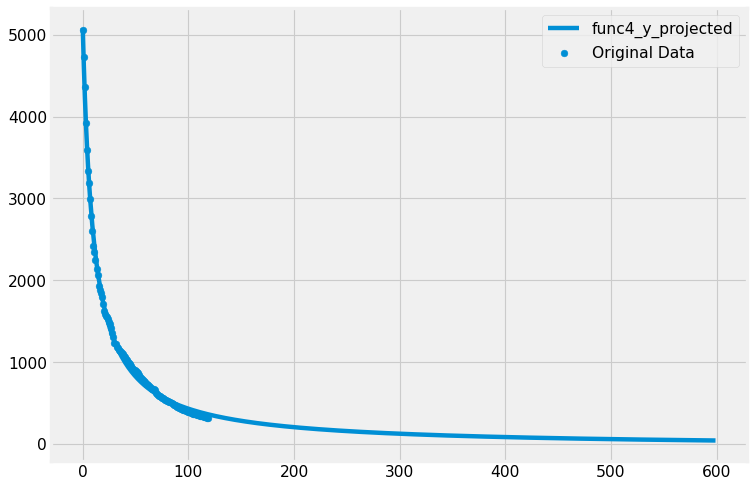

In [74]:
plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data_A['level_number'], data_A['unique_start_qty'], label="Original Data" )
plt.plot( func4_y_projected, label="func4_y_projected" )

plt.legend()
plt.show()

In [75]:
print('Средняя абсолютная ошибка:', mean_absolute_error(data_A.iloc[:,1].values, func4_y_projected[:120]))
print('Среднеквадратичная ошибка:', mean_squared_error(data_A.iloc[:,1].values, func4_y_projected[:120]))
print('Коэффициент детерминации (r2_score):', r2_score(data_A.iloc[:,1].values, func4_y_projected[:120]))

Средняя абсолютная ошибка: 38.96670827962839
Среднеквадратичная ошибка: 2123.579455643196
Коэффициент детерминации (r2_score): 0.9976324024120404


MSE высокая, но коэф детерминации близок к 100%. Посмотрим искомые значения

In [97]:
avg_240_qty = sum(func4_y_projected[:240]*np.linspace(1,240,240, dtype='int'))/sum(func4_y_projected[:240])
avg_360_qty = sum(func4_y_projected[:360]*np.linspace(1,360,360, dtype='int'))/sum(func4_y_projected[:360])
avg_480_qty = sum(func4_y_projected[:480]*np.linspace(1,480,480, dtype='int'))/sum(func4_y_projected[:480])
avg_600_qty = sum(func4_y_projected[:600]*np.linspace(1,600,600, dtype='int'))/sum(func4_y_projected[:600])

In [99]:
print('Пользователь в среднем проходил бы:')
print(int(avg_240_qty), 'уровней при общем количестве в 240')
print(int(avg_360_qty), 'уровень при общем количестве в 360')
print(int(avg_480_qty), 'уровней при общем количестве в 480')
print(int(avg_600_qty), 'уровней при общем количестве в 600')


Пользователь в среднем проходил бы:
60 уровней при общем количестве в 240
81 уровень при общем количестве в 360
98 уровней при общем количестве в 480
112 уровней при общем количестве в 600


## 2.3
Предположите, сколько нужно уровней, чтобы снять достоверный Retention D30

Retention 30 дня является четким сигналом, характеризующим глубину геймплея и метаигры. Маловероятно, что многие пользователи продолжат играть в игру более тридцати дней, если в ней нет глубокой и качественной метаигры и, зачастую, если она не предлагает глубокого социального опыта.

Посмотрим бенчмарки по рынку казуальных игр. Средний Retention D30 = 5%. Опираяся на нашу первую модель, нам необходимо около **166 уровней**, чтобы снять достоверный Retention 30.

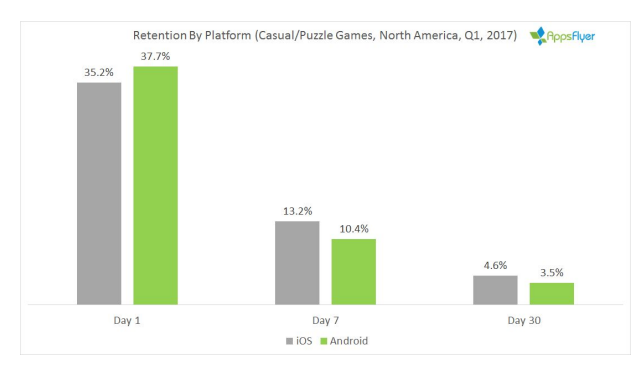

# Задание 3

В качестве эксперимента протестировали два разных варианта баланса
уровней(A/B). Через месяц получили следующие результаты. Как вы считаете, когорта с каким балансом перспективнее? Почему?

In [ ]:
df = pd.DataFrame({'size': [500,500],
                   'paying_share': [0.1,0.14],
                   'ARPU': [1,0.8],
                   'Retention_D30': [0.05,0.04]},      
                  index=['chogort_A', 'chogort_B'])
df.head()

,size,paying_share,ARPU,Retention_D30
chogort_A,500,0.10,1.0,0.05
chogort_B,500,0.14,0.8,0.04


In [ ]:
df['gross'] = df['size']*df['ARPU']
df['ARPPU'] = (df['ARPU']/df['paying_share']).round(1)
df

,size,paying_share,ARPU,Retention_D30,gross,ARPPU
chogort_A,500,0.10,1.0,0.05,500.0,10.0
chogort_B,500,0.14,0.8,0.04,400.0,5.7


На мой взгляд, баланс **когорты А** перспективнее.

Ключевые показатели **ARPU** и **ARPPU** выше соответствующих показателей когорты В. То есть, в корорте А средний доход на всех пользователей и доход на одного платящего пользователя выше. 

**D30 Retention** также больше в корогте А. Он показывает процент пользователей, которые уже освоили функционал приложения и периодически его используют. Они, скорее всего, уже привыкли к нему и не планируют менять его на что-то другое в ближайшем будущем. Именно эти люди, с высокой вероятностью, будут совершать платежи в продукте. 

В **когорте В** игроки начинают быстро проходить все уровни, в итоге теряют интерес к игре и отваливаются. 